In [1]:
from src import Processor, Reader
import pandas as pd
from datetime import datetime
from sklearn import metrics, model_selection, preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import numpy as np

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()

In [2]:
# Using the US Census regions from here: https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf
south_atlantic_states = [
    10   # Delaware
    , 11 # DC
    , 12 # Florida
    , 13 # Georgia
    , 24 # Maryland
    , 37 # North Carolina
    , 45 # South Carolina
    , 51 # Virginia
    , 54 # West Virginia
]
state_filter = south_atlantic_states

In [3]:
state_dict = {
    'code' : ['10', '11', '12', '13', '24', '37', '45', '51', '54']
    , 'state_name' : ['Delware', 'DC', 'Florida', 'Georgia', 'Maryland', 'North Carolina', 'South Carolina', 'Virginia', 'West Virginia']
}

state_code_map = pd.DataFrame(data=state_dict)

In [4]:
state_code_map.head()

,code,state_name
0,10,Delware
1,11,DC
2,12,Florida
3,13,Georgia
4,24,Maryland


## Loading data

In [5]:
# Instantiate preprocessor
#preprocessor = Processor.PreProcessor(state_filter=state_filter)

In [6]:
#preprocessor.load_processed_data()

In [7]:
# Put data into a df to work with
#df = preprocessor.get_current_data()

In [8]:
#df.head()

In [9]:
# Export data to csv so that the data does not have to be recreated each run
#df.to_csv('COVID_Analysis_Data.csv',index=False)

In [10]:
#data = df
data = pd.read_csv("COVID_Analysis_Data.csv")

In [11]:
# Converting date column for filtering
#data['date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))

# Filtering data by date for training dataset
end_date_train = '2021-06-14'
train_mask = (data['date'] <= end_date_train)

# Training dataset with date (wd)
data_train_wd = data.loc[train_mask]

# Creating training dataset and removing date
data_train = data_train_wd.drop(columns=['date'])

In [12]:
# Filtering data by date for test dataset
start_date_test = '2021-06-15'
test_mask = (data['date'] >= start_date_test)

# Test dataset with date (wd)
data_test_wd = data.loc[test_mask]

# Creating training dataset and removing date
data_test = data_test_wd.drop(columns=['date'])

In [13]:
# Separating out columns to exclude response variables for training and testing
data_train_cols = [c for c in data_train.columns if c not in ['cases','deaths']]
data_test_cols = [c for c in data_test.columns if c not in ['cases','deaths']]

In [14]:
# Creating training predictors and response variables
X_train = data_train[data_train_cols]
y_train_cases = data_train['cases']
y_train_deaths = data_train['deaths']

# Creating testing predictors and response variables
X_test = data_test[data_test_cols]
y_test_cases = data_test['cases']
y_test_deaths = data_test['deaths']

In [15]:
# Evaluating training data
data_train.head()

,FIPS_10001,FIPS_10003,FIPS_10005,FIPS_11001,FIPS_12001,FIPS_12003,FIPS_12005,FIPS_12007,FIPS_12009,FIPS_12011,...,restuarants_limited_open_outdoor_only_nan,restuarants_limited_open_general_indoor_Yes,restuarants_limited_open_general_indoor_nan,Series_Complete_Pop_Pct,Administered_Dose1_Pop_Pct,is_metro,Series_Complete_Pop_Pct_UR_Equity,cases,deaths,days_from_start
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,230.0,3.0,0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,255.0,4.0,1
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,281.0,4.0,2
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,288.0,6.0,3
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,329.0,7.0,4


In [16]:
# Evaluating the size of the training and test datasets
print(data_train.shape)
print(data_test.shape)

(253428, 698)
(36456, 698)


In [17]:
set(data_train.columns) - set(X_train.columns)

{'cases', 'deaths'}

In [18]:
from src import Modeler

In [19]:
modeler = Modeler.Modeler()

In [20]:
X_train, y_train_cases, y_train_deaths, X_test, y_test_cases, y_test_deaths = modeler.split_train_test(data, '2021-06-14')

In [21]:
X_train.shape

(253428, 696)

In [22]:
X_test.shape

(36456, 696)

In [23]:
# Testing on cases

model = LinearRegression()

scores = model_selection.cross_validate(model, X_train, y_train_cases, cv=5, scoring='neg_root_mean_squared_error')
    
## Training model on entire training dataset
model.fit(X_train, y_train_cases)

y_preds = model.predict(X_test)

print()
# The mean square error
rmse = np.sqrt(np.mean((y_preds - y_test_cases) ** 2))
print(rmse)


15435.418943826164


In [24]:
scores

{'fit_time': array([7.92959785, 7.72045422, 7.82728195, 7.64826107, 7.67851424]),
 'score_time': array([0.19277811, 0.0815239 , 0.08058596, 0.08427382, 0.08150673]),
 'test_score': array([-1.94369925e+11, -9.94509702e+03, -1.55268620e+11, -3.15031505e+11,
        -1.35599502e+11])}

In [25]:
np.mean(scores['test_score'])

-160053912251.23428

In [26]:
# testing CV function
modeler.cv_model(model, X_train, y_train_cases)

{'Negative RMSE': (-160053912251.23428, 101423677466.20297),
 'r2': (-892314827737360.5, 1566997173352786.8),
 'Explained Variance': (-846390332095903.8, 1485702557544473.0)}

In [27]:
# testing out dropping FIPS and seeing if that improves the fit:
data_no_fips = data[[c for c in data.columns if c[:4] != 'FIPS']]

In [28]:
X_train, y_train_cases, y_train_deaths, X_test, y_test_cases, y_test_deaths = modeler.split_train_test(data_no_fips, '2021-06-14')

In [29]:
modeler.cv_model(model, X_train, y_train_cases)

{'Negative RMSE': (-19926305241.19329, 39852579134.37397),
 'r2': (-331332429153951.6, 662664858307903.0),
 'Explained Variance': (-314066126822018.3, 628132253644036.6)}

In [30]:
data_no_fl = data[data['STATE_12'] != 1].drop(['STATE_12'], axis=1)
data_no_fl = data_no_fl.drop([c for c in data_no_fl.columns if c[:7] == 'FIPS_12'], axis=1)

In [31]:
X_train, y_train_cases, y_train_deaths, X_test, y_test_cases, y_test_deaths = modeler.split_train_test(data_no_fl, '2021-06-14')

In [32]:
modeler.cv_model(model, X_train, y_train_cases)

{'Negative RMSE': (-796966335792.468, 884869289939.1213),
 'r2': (-6.431345340581976e+16, 1.0446155089381352e+17),
 'Explained Variance': (-6.085769025607292e+16, 9.922036654706757e+16)}

In [33]:
data_only_va = data[data['STATE_51'] == 1].drop([c for c in data.columns if c[:5] == 'STATE'], axis=1)
data_only_va = data_only_va.drop([c for c in data_only_va.columns if (c[:4] == 'FIPS' and c[:7] != 'FIPS_51')], axis=1)

In [34]:
X_train, y_train_cases, y_train_deaths, X_test, y_test_cases, y_test_deaths = modeler.split_train_test(data_only_va, '2021-06-14')

In [35]:
modeler.cv_model(model, X_train, y_train_cases)

{'Negative RMSE': (-5455.914296819463, 1491.944497017455),
 'r2': (-2.6059631148428637, 2.595949615535293),
 'Explained Variance': (-2.574148663120521, 2.575840084938748)}

In [42]:
y_pred_cases, rmse, r2 = modeler.test_model(model, X_train, y_train_cases, X_test, y_test_cases)

RMSE: 4693.97
R^2 Score: 0.75


In [47]:
## Very Optional
def plot_predictions(y_test, y_pred):
    plt.scatter(y_test, y_pred, color='none', edgecolor='b')
    xymin = min(np.min(y_test), np.min(y_pred))
    xymax = max(np.max(y_test), np.max(y_pred))
    plt.plot([xymin, xymax],[xymin, xymax], color="r", linestyle="--")
    plt.show()

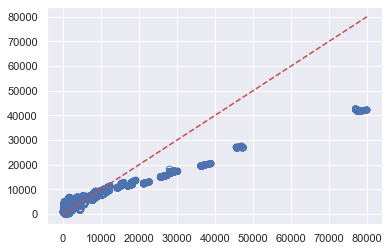

In [48]:
plot_predictions(y_test_cases, y_pred_cases)

In [49]:
residuals = y_preds - y_test_cases

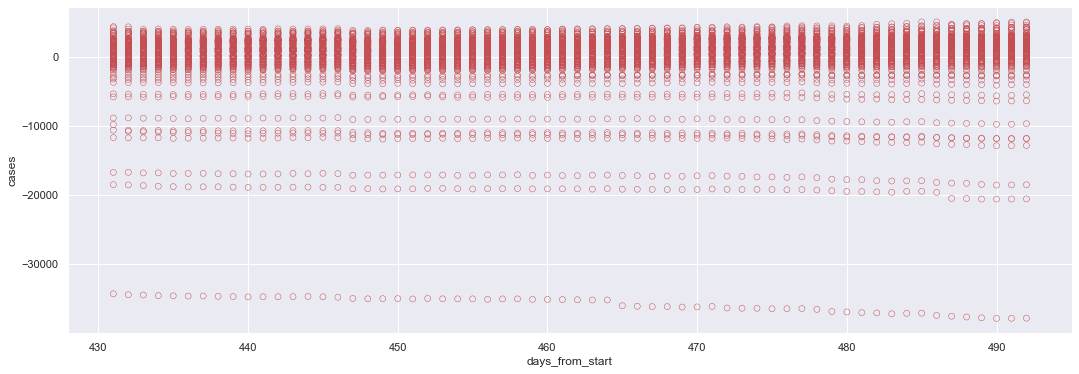

In [50]:
plt.figure(figsize=(18, 6))
sns.scatterplot(x=X_test['days_from_start'], y=residuals, color='none', edgecolor='r')
plt.show()
# TODO what happens if we remove these outliers?
# Does the model fit improve significantly?

In [29]:
# Test out combining all of the data for a single state and seeing how far off cases/deaths predictions were?


# Decision Tree

In [36]:
# Testing on cases

model_dt = DecisionTreeRegressor()

scores_dt = model_selection.cross_validate(model_dt, X_train, y_train_cases, cv=5, scoring='neg_root_mean_squared_error')
    
## Training model on entire training dataset
model_dt.fit(X_train, y_train_cases)

y_preds_dt = model_dt.predict(X_test)

print()
# The mean square error
rmse_dt = np.sqrt(np.mean((y_preds_dt - y_test_cases) ** 2))



## KNN Regressor

In [47]:
# Testing on cases

model_knn = KNeighborsRegressor()

scores_knn = model_selection.cross_validate(model_knn, X_train, y_train_cases, cv=5, scoring='neg_root_mean_squared_error')
    
## Training model on entire training dataset
model_knn.fit(X_train, y_train_cases)

y_preds_knn = model_knn.predict(X_test)

print()
# The mean square error
rmse_knn= np.sqrt(np.mean((y_preds_knn - y_test_cases) ** 2))



In [48]:
print('Decision tree RMSE:', rmse_dt)
print('Linear Regression RMSE:', rmse)
print('KNN Regression RMSE:', rmse_knn)

Decision tree RMSE: 2528.296114326018
Linear Regression RMSE: 15435.418943826164
KNN Regression RMSE: 27567.813074539386


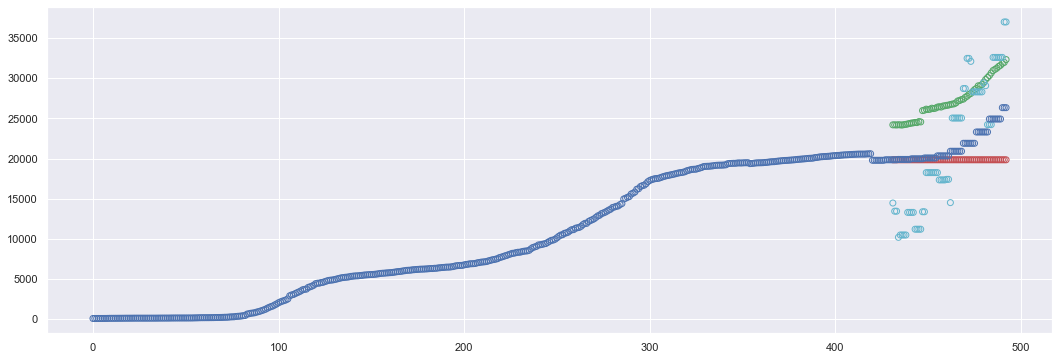

In [55]:
# Checking out how the prediction looked vs the model
county_mask = X_test['FIPS_12005'] == 1
county_mask_train = X_train['FIPS_12005'] == 1
plt.figure(figsize=(18, 6))
plt.scatter(x=X_test[county_mask]['days_from_start'], y=y_preds_dt[county_mask], color='none', edgecolor='r')
plt.scatter(x=X_test[county_mask]['days_from_start'], y=y_preds[county_mask], color='none', edgecolor='g')
plt.scatter(x=X_test[county_mask]['days_from_start'], y=y_preds_knn[county_mask], color='none', edgecolor='c')
plt.scatter(x=X_train[county_mask_train]['days_from_start'], y=y_train_cases[county_mask_train], color='none', edgecolor='b')
plt.scatter(x=X_test[county_mask]['days_from_start'], y=y_test_cases[county_mask], color='none', edgecolor='b');

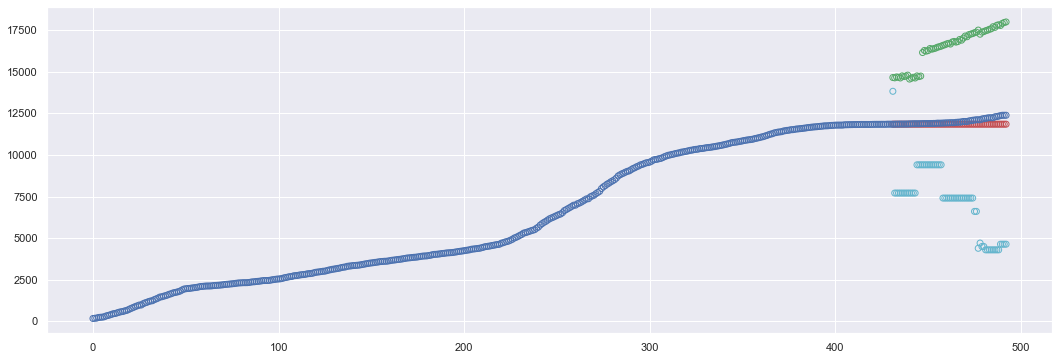

In [54]:
# Checking out how the prediction looked vs the model (Alexandria, VA FIPS 51510)
county_mask = X_test['FIPS_51510'] == 1
county_mask_train = X_train['FIPS_51510'] == 1
plt.figure(figsize=(18, 6))
plt.scatter(x=X_test[county_mask]['days_from_start'], y=y_preds_dt[county_mask], color='none', edgecolor='r')
plt.scatter(x=X_test[county_mask]['days_from_start'], y=y_preds[county_mask], color='none', edgecolor='g')
plt.scatter(x=X_test[county_mask]['days_from_start'], y=y_preds_knn[county_mask], color='none', edgecolor='c')
plt.scatter(x=X_train[county_mask_train]['days_from_start'], y=y_train_cases[county_mask_train], color='none', edgecolor='b')
plt.scatter(x=X_test[county_mask]['days_from_start'], y=y_test_cases[county_mask], color='none', edgecolor='b');

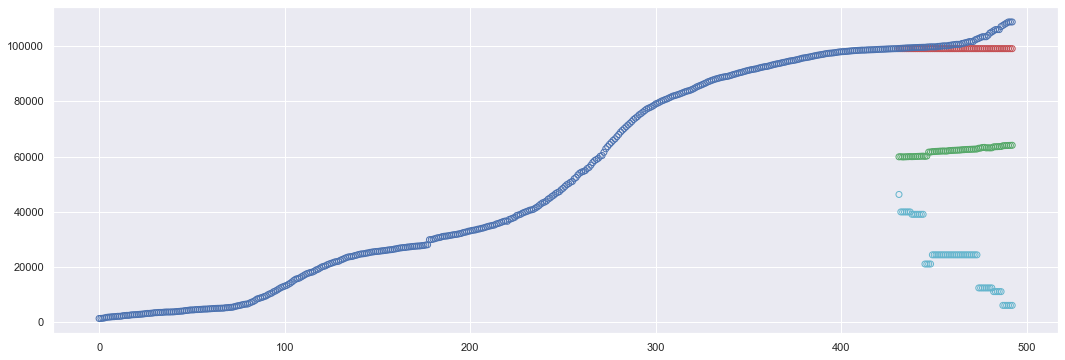

In [53]:
# Checking out how the prediction looked vs the model (Atlanta, GA Fulton county 13121)
county_mask = X_test['FIPS_13121'] == 1
county_mask_train = X_train['FIPS_13121'] == 1
plt.figure(figsize=(18, 6))
plt.scatter(x=X_test[county_mask]['days_from_start'], y=y_preds_dt[county_mask], color='none', edgecolor='r')
plt.scatter(x=X_test[county_mask]['days_from_start'], y=y_preds[county_mask], color='none', edgecolor='g')
plt.scatter(x=X_test[county_mask]['days_from_start'], y=y_preds_knn[county_mask], color='none', edgecolor='c')
plt.scatter(x=X_train[county_mask_train]['days_from_start'], y=y_train_cases[county_mask_train], color='none', edgecolor='b')
plt.scatter(x=X_test[county_mask]['days_from_start'], y=y_test_cases[county_mask], color='none', edgecolor='b');

In [46]:
y_train_cases[county_mask_train].values[-1]

99058.0

In [45]:
y_preds_dt[county_mask]

array([99058., 99058., 99058., 99058., 99058., 99058., 99058., 99058.,
       99058., 99058., 99058., 99058., 99058., 99058., 99058., 99058.,
       99058., 99058., 99058., 99058., 99058., 99058., 99058., 99058.,
       99058., 99058., 99058., 99058., 99058., 99058., 99058., 99058.,
       99058., 99058., 99058., 99058., 99058., 99058., 99058., 99058.,
       99058., 99058., 99058., 99058., 99058., 99058., 99058., 99058.,
       99058., 99058., 99058., 99058., 99058., 99058., 99058., 99058.,
       99058., 99058., 99058., 99058., 99058., 99058.])